## Importing Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds  
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from helper_functions import *

## About dataset

Food 101 is a large scale food iamge dataset used computer vision designed for food recognition and classification.

Details of Food 101:
- Total images 101,000 images of 101 categories of foods.
- each fodd contains 1000 images.
- these are real world images with all the variability.
- max side length of the image 512px.

## Using tensorflow datasets to import data

In [ ]:
#Loading the dataset from tensorflow
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True
                                             )

## Exploring the Food101 data from Tensorflow datasets

In [3]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [4]:
# checking the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# Output the information about sample image
for image, label in train_one_sample:
    print(f'''
          Image shape: {image.shape}
          Image datatype: {image.dtype}
          Target class from Food101 (tensor form): {label}
          Class name (str form): {class_names[label.numpy()]}
        ''')


          Image shape: (512, 512, 3)
          Image datatype: <dtype: 'uint8'>
          Target class from Food101 (tensor form): 41
          Class name (str form): french_onion_soup
        


2024-09-25 09:17:59.188872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


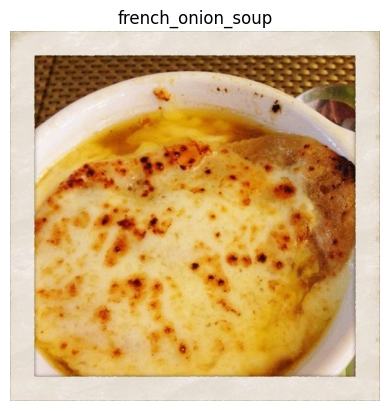

In [8]:
#Plotting a image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [9]:
# Lets take a look at min and max values in the image tensor
np.min(image),np.max(image)

(0, 255)

## Creating preprocessing functions for data

In [10]:
# creating a function to preprocess the image
def preprocess_image(image, label, image_size= 224, scale=False):
    image = tf.image.resize(image, [image_size, image_size])
    if scale:
        image = image/255.
    return tf.cast(image, tf.float32), label

In [11]:
# preprocess a single sample image and check the outputs
preprocessed_image = preprocess_image(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}\n')
print(f'Image after preprocessing:\n {preprocessed_image[:2]}...., \nShape: {preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}')

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]...., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]...., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## batching and prepare data

In [12]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating the Model callbacks

In [14]:
import datetime
import os
#Create tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    return tensorboard_callback


# Create the ModelCheckpoint to save model
checkpoint_path = 'Food_Vision/checkpoints.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor = 'val_accuracy',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      save_freq = 'epoch')

## Setting up mixed precision training

In [15]:
# Turn on Mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Building Feature extractor Model with EfficientNetB0

In [16]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation(activation='softmax',dtype=tf.float32, name = 'softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Checking the layer dtype policies

In [17]:
for i, layer in enumerate(model.layers[1].layers):
    print(i, layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

0 input_layer float32 <DTypePolicy "mixed_float16"> False
1 rescaling float32 <DTypePolicy "mixed_float16"> False
2 normalization float32 <DTypePolicy "mixed_float16"> False
3 stem_conv float32 <DTypePolicy "mixed_float16"> False
4 stem_bn float32 <DTypePolicy "mixed_float16"> False
5 stem_activation float32 <DTypePolicy "mixed_float16"> False
6 block1a_project_conv float32 <DTypePolicy "mixed_float16"> False
7 block1a_project_bn float32 <DTypePolicy "mixed_float16"> False
8 block1a_project_activation float32 <DTypePolicy "mixed_float16"> False
9 block2a_expand_conv float32 <DTypePolicy "mixed_float16"> False
10 block2a_expand_bn float32 <DTypePolicy "mixed_float16"> False
11 block2a_expand_activation float32 <DTypePolicy "mixed_float16"> False
12 block2a_project_conv float32 <DTypePolicy "mixed_float16"> False
13 block2a_project_bn float32 <DTypePolicy "mixed_float16"> False
14 block2b_expand_conv float32 <DTypePolicy "mixed_float16"> False
15 block2b_expand_bn float32 <DTypePolicy "m

## Fitting the data on Feature extraction model

### validating the model on 15% of the test_data

In [18]:
#Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

history_101_feature_extraction_model_15_percent = model.fit(train_data,
                                                 epochs = 5,
                                                validation_data = test_data,
                                                 validation_steps = int(0.15 * len(test_data)),
                                                 callbacks = [create_tensorboard_callback('Project_training_logs',
                                                                                          'efficientnetb0_101_foods_15_percent_feature_extract_model'),
                                                              model_checkpoint])

Epoch 1/5


2024-09-25 09:18:03.557876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 414s 170ms/step - accuracy: 0.4610 - loss: 2.3563 - val_accuracy: 0.6883 - val_loss: 1.1759
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 396s 167ms/step - accuracy: 0.6537 - loss: 1.3382 - val_accuracy: 0.7238 - val_loss: 1.0355
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 393s 166ms/step - accuracy: 0.6917 - loss: 1.1928 - val_accuracy: 0.7243 - val_loss: 0.9944
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 396s 167ms/step - accuracy: 0.7078 - loss: 1.1044 - val_accuracy: 0.7373 - val_loss: 0.9531
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 393s 166ms/step - accuracy: 0.7286 - loss: 1.0256 - val_accuracy: 0.7397 - val_loss: 0.9561


In [19]:
#Evaluate model on whole dataset
results_feature_extract_model_15_percent = model.evaluate(test_data)
results_feature_extract_model_15_percent

790/790 ━━━━━━━━━━━━━━━━━━━━ 125s 159ms/step - accuracy: 0.7412 - loss: 0.9608


[0.956373393535614, 0.7405544519424438]

<Axes: >

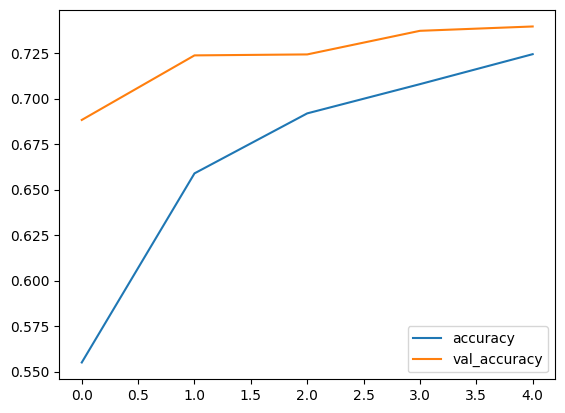

In [20]:
history_101_feature_extraction_model_15_percent = pd.DataFrame(history_101_feature_extraction_model_15_percent.history)
history_101_feature_extraction_model_15_percent[['accuracy','val_accuracy']].plot()

<Axes: >

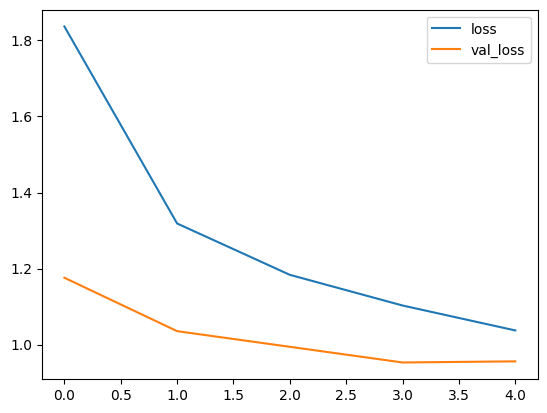

In [21]:
history_101_feature_extraction_model_15_percent[['loss','val_loss']].plot()

In [22]:
#saving the model
model.save('101_food_feature_extract_model_15_percent.keras')

### validating the model on full test_data

In [23]:
#Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

history_101_feature_extraction_model_all_data = model.fit(train_data,
                                                 epochs = 5,
                                                validation_data = test_data,
                                                 callbacks = [create_tensorboard_callback('Project_training_logs',
                                                                                          'efficientnetb0_101_foods_all_data_feature_extract_model'),
                                                              model_checkpoint])

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 503s 208ms/step - accuracy: 0.7344 - loss: 0.9946 - val_accuracy: 0.7410 - val_loss: 0.9527
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 514s 217ms/step - accuracy: 0.7487 - loss: 0.9492 - val_accuracy: 0.7410 - val_loss: 0.9402
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 513s 216ms/step - accuracy: 0.7537 - loss: 0.9139 - val_accuracy: 0.7416 - val_loss: 0.9414
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 504s 213ms/step - accuracy: 0.7581 - loss: 0.8905 - val_accuracy: 0.7441 - val_loss: 0.9367
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 495s 209ms/step - accuracy: 0.7648 - loss: 0.8609 - val_accuracy: 0.7425 - val_loss: 0.9436


In [24]:
#Evaluate model on whole dataset
results_feature_extract_model_all_data = model.evaluate(test_data)
results_feature_extract_model_all_data

790/790 ━━━━━━━━━━━━━━━━━━━━ 122s 155ms/step - accuracy: 0.7425 - loss: 0.9479


[0.9436197280883789, 0.742495059967041]

<Axes: >

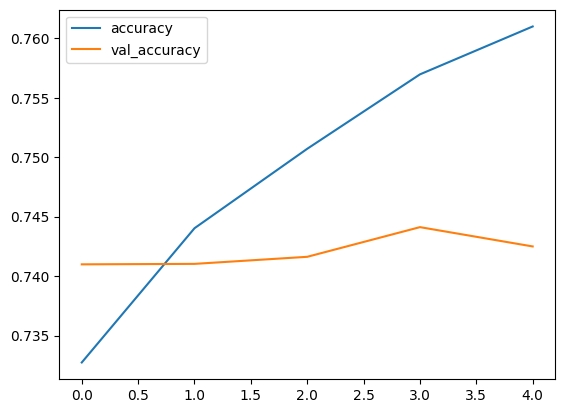

In [25]:
history_101_feature_extraction_model_all_data = pd.DataFrame(history_101_feature_extraction_model_all_data.history)
history_101_feature_extraction_model_all_data[['accuracy','val_accuracy']].plot()

<Axes: >

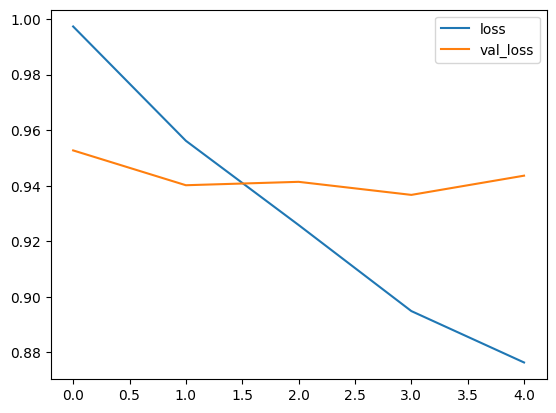

In [26]:
history_101_feature_extraction_model_all_data[['loss','val_loss']].plot()

In [27]:
#saving the model
model.save('101_food_feature_extract_model_all_data.keras')

In [28]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

loaded_feature_extract_model = tf.keras.models.load_model('./101_food_feature_extract_model_all_data.keras')

In [29]:
#checking all the layers of model
for i, layer in enumerate(loaded_feature_extract_model.layers):
    print(i, layer.name, layer.trainable, layer.dtype)

0 input_layer True float32
1 efficientnetv2-b0 False float32
2 global_average_pooling True float32
3 dense True float32
4 softmax_float32 True float32


In [30]:
# checking the layers of the base model
for i, layer in enumerate(loaded_feature_extract_model.layers[1].layers):
    print(i, layer.name, layer.trainable, layer.dtype)

0 input_layer True float32
1 rescaling False float32
2 normalization False float32
3 stem_conv False float32
4 stem_bn False float32
5 stem_activation False float32
6 block1a_project_conv False float32
7 block1a_project_bn False float32
8 block1a_project_activation False float32
9 block2a_expand_conv False float32
10 block2a_expand_bn False float32
11 block2a_expand_activation False float32
12 block2a_project_conv False float32
13 block2a_project_bn False float32
14 block2b_expand_conv False float32
15 block2b_expand_bn False float32
16 block2b_expand_activation False float32
17 block2b_project_conv False float32
18 block2b_project_bn False float32
19 block2b_drop False float32
20 block2b_add False float32
21 block3a_expand_conv False float32
22 block3a_expand_bn False float32
23 block3a_expand_activation False float32
24 block3a_project_conv False float32
25 block3a_project_bn False float32
26 block3b_expand_conv False float32
27 block3b_expand_bn False float32
28 block3b_expand_activ

In [31]:
#evaluating the loaded model on the test_data
loaded_feature_extract_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - accuracy: 0.7425 - loss: 0.9488


[0.9436193704605103, 0.742495059967041]

## Finetuning Model

In [32]:
#layers of the model
for i,layer in enumerate(model.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [33]:
for i, layer in enumerate(model.layers[1].layers[-50:]):
    print(i, layer.name, layer.trainable)
    layer.trainable = True
    print(i, layer.name, layer.trainable)

0 block6e_drop False
0 block6e_drop True
1 block6e_add False
1 block6e_add True
2 block6f_expand_conv False
2 block6f_expand_conv True
3 block6f_expand_bn False
3 block6f_expand_bn True
4 block6f_expand_activation False
4 block6f_expand_activation True
5 block6f_dwconv2 False
5 block6f_dwconv2 True
6 block6f_bn False
6 block6f_bn True
7 block6f_activation False
7 block6f_activation True
8 block6f_se_squeeze False
8 block6f_se_squeeze True
9 block6f_se_reshape False
9 block6f_se_reshape True
10 block6f_se_reduce False
10 block6f_se_reduce True
11 block6f_se_expand False
11 block6f_se_expand True
12 block6f_se_excite False
12 block6f_se_excite True
13 block6f_project_conv False
13 block6f_project_conv True
14 block6f_project_bn False
14 block6f_project_bn True
15 block6f_drop False
15 block6f_drop True
16 block6f_add False
16 block6f_add True
17 block6g_expand_conv False
17 block6g_expand_conv True
18 block6g_expand_bn False
18 block6g_expand_bn True
19 block6g_expand_activation False
19

In [34]:
# creating a learning rate decay function
def learning_rate_decay(initial_lr, epoch, decay_percent, min_lr=0.00001):
    if epoch<5:
        return initial_lr
    else:
        decayed_lr = initial_lr * ((1-decay_percent)**(epoch-4))
        return max(decayed_lr, min_lr)

# creating the learning rate callback
learning_rate_callback  = tf.keras.callbacks.LearningRateScheduler(learning_rate_decay)


In [35]:
#creating early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience = 3)

In [36]:
# model checkpoint
finetune_checkpoint_path = 'Food_Vision_finetuned/checkpoint.weights.h5'
finetune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=finetune_checkpoint_path,
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      save_freq = 'epoch')

In [37]:
initial_epochs = 5

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_101_finetuned_model = model.fit(train_data,
                                        validation_data = test_data,
                                        validation_steps = int(0.15*len(test_data)),
                                        initial_epoch = initial_epochs,
                                        epochs = initial_epochs+3,
                                        callbacks = [early_stopping,
                                                     finetune_model_checkpoint,
                                                     create_tensorboard_callback('Project_training_logs','efficientnetb0_101_foods_all_data_fine_tuned_model')
                                        ]
                                        )

Epoch 6/8
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 568s 233ms/step - accuracy: 0.7092 - loss: 1.0905 - val_accuracy: 0.7590 - val_loss: 0.8705
Epoch 7/8
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 548s 231ms/step - accuracy: 0.7966 - loss: 0.7428 - val_accuracy: 0.7799 - val_loss: 0.8098
Epoch 8/8
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 549s 232ms/step - accuracy: 0.8321 - loss: 0.6210 - val_accuracy: 0.7720 - val_loss: 0.8042


In [38]:
#Evaluating the model on full data and with 100 epochs to train to get the best results
initial_epochs = 8

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_101_finetuned_model = model.fit(train_data,
                                        validation_data = test_data,
                                        initial_epoch = initial_epochs,
                                        epochs = initial_epochs+100,
                                        callbacks = [early_stopping,
                                                     finetune_model_checkpoint,
                                                     create_tensorboard_callback('Project_training_logs','efficientnetb0_101_foods_all_data_fine_tuned_model')
                                        ]
                                        )

Epoch 9/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 676s 278ms/step - accuracy: 0.8557 - loss: 0.5263 - val_accuracy: 0.7855 - val_loss: 0.7848
Epoch 10/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 650s 274ms/step - accuracy: 0.8835 - loss: 0.4406 - val_accuracy: 0.7865 - val_loss: 0.7880
Epoch 11/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 656s 277ms/step - accuracy: 0.9033 - loss: 0.3713 - val_accuracy: 0.7884 - val_loss: 0.7864
Epoch 12/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 650s 274ms/step - accuracy: 0.9160 - loss: 0.3242 - val_accuracy: 0.7907 - val_loss: 0.7887
Epoch 13/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 650s 274ms/step - accuracy: 0.9304 - loss: 0.2777 - val_accuracy: 0.7925 - val_loss: 0.7893
Epoch 14/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 651s 275ms/step - accuracy: 0.9390 - loss: 0.2416 - val_accuracy: 0.7931 - val_loss: 0.7957
Epoch 15/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 652s 275ms/step - accuracy: 0.9455 - loss: 0.2183 - val_accuracy: 0.7909 - val_loss: 0.8095
Epoch 16/108
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 652s 

In [39]:
model.save('101_food_fine_tuned_model.keras')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./transfer_learning
%tensorboard --stop

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,221,221 (38.99 MB)

 Trainable params: 2,086,261 (7.96 MB)

 Non-trainable params: 3,962,432 (15.12 MB)

 Optimizer params: 4,172,528 (15.92 MB)

## Evaluating the Finetuned Model

In [41]:
#loading the test data from directory 
test_data_dir = '101_food_classes_10_percent/test'

test_data_all = preprocessing.image_dataset_from_directory(test_data_dir, label_mode='categorical', shuffle=False, image_size=(224,224))

Found 25250 files belonging to 101 classes.


In [42]:
pred_probs = model.predict(test_data_all)

790/790 ━━━━━━━━━━━━━━━━━━━━ 132s 161ms/step


In [43]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([85,  0,  8,  0,  0, 59, 29,  0,  0,  0])

In [44]:
y_labels = []
for image, labels in test_data_all.unbatch():
    y_labels.append(labels.numpy().argmax())

2024-09-25 17:05:06.972110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
y_labels[-10:]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

In [47]:
pred_classes[-10:]

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [48]:
# Accuracy of the Model
accuracy_score(y_labels, pred_classes)

0.7787722772277228

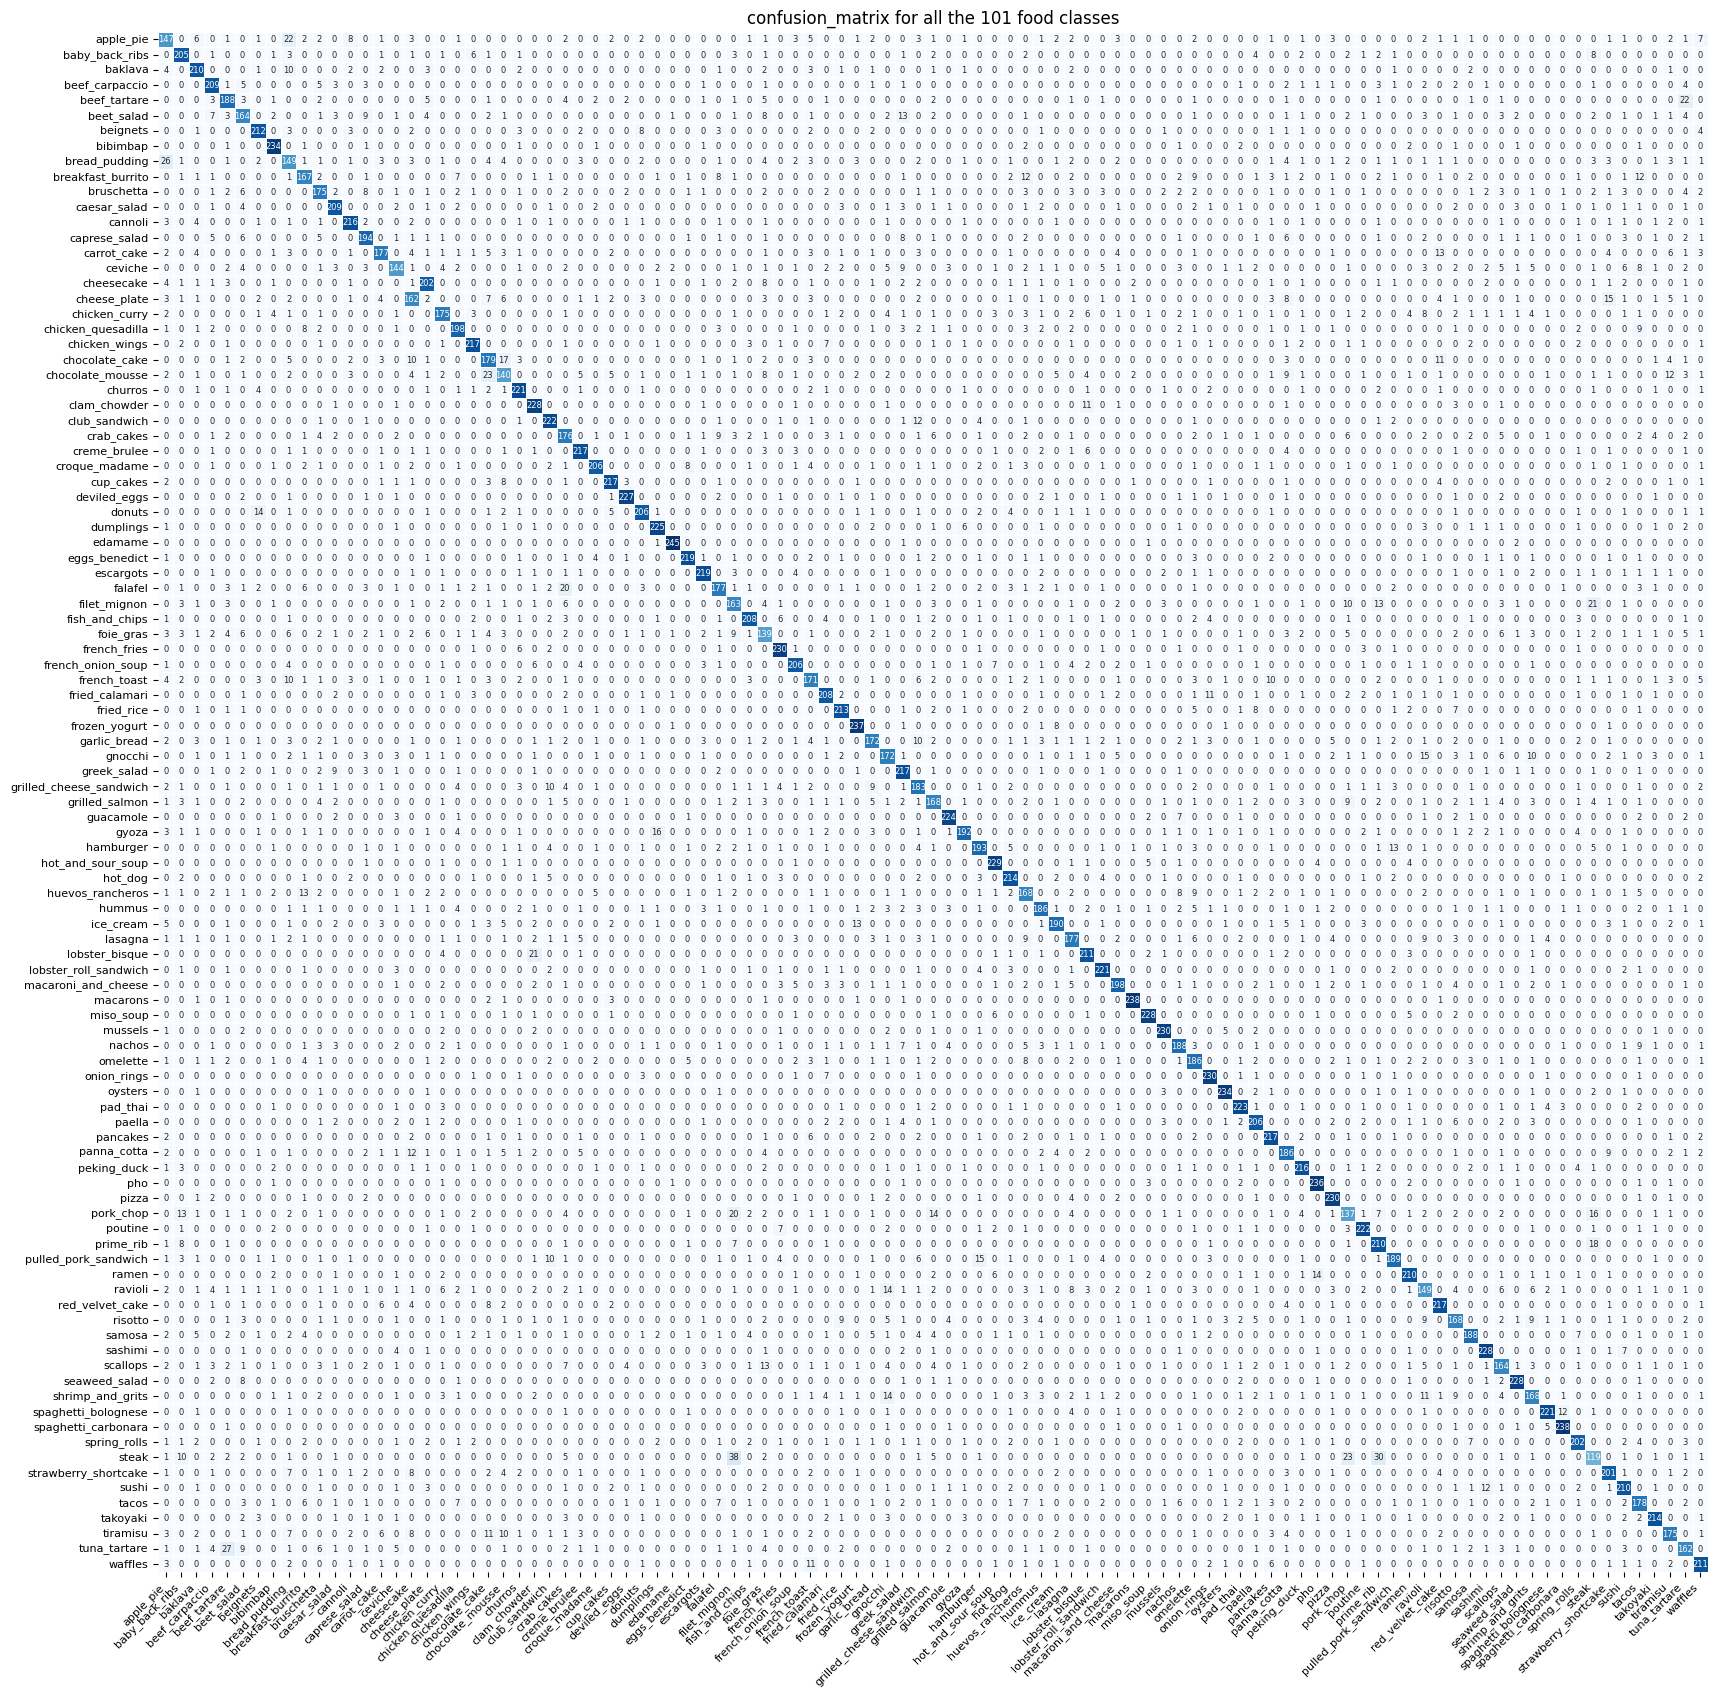

In [72]:
#confusion_matrix
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_labels, pred_classes), annot=True, annot_kws={'size': 6},
             cbar=False,cmap='Blues', fmt='d', linewidths=0.5, xticklabels=class_names, yticklabels=class_names)
plt.title('confusion_matrix for all the 101 food classes')
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [49]:
#Classification report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       250
           1       0.76      0.82      0.79       250
           2       0.80      0.84      0.82       250
           3       0.80      0.84      0.82       250
           4       0.71      0.75      0.73       250
           5       0.66      0.66      0.66       250
           6       0.84      0.85      0.84       250
           7       0.88      0.94      0.91       250
           8       0.57      0.60      0.58       250
           9       0.74      0.67      0.70       250
          10       0.71      0.70      0.71       250
          11       0.82      0.84      0.83       250
          12       0.87      0.86      0.87       250
          13       0.78      0.78      0.78       250
          14       0.83      0.71      0.76       250
          15       0.74      0.58      0.65       250
          16       0.00      0.00      0.00       250
          17       0.01    

In [50]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.5951417004048583,
  'recall': 0.588,
  'f1-score': 0.5915492957746479,
  'support': 250.0},
 '1': {'precision': 0.7620817843866171,
  'recall': 0.82,
  'f1-score': 0.789980732177264,
  'support': 250.0},
 '2': {'precision': 0.8045977011494253,
  'recall': 0.84,
  'f1-score': 0.821917808219178,
  'support': 250.0},
 '3': {'precision': 0.8007662835249042,
  'recall': 0.836,
  'f1-score': 0.8180039138943248,
  'support': 250.0},
 '4': {'precision': 0.706766917293233,
  'recall': 0.752,
  'f1-score': 0.7286821705426356,
  'support': 250.0},
 '5': {'precision': 0.6639676113360324,
  'recall': 0.656,
  'f1-score': 0.6599597585513078,
  'support': 250.0},
 '6': {'precision': 0.8379446640316206,
  'recall': 0.848,
  'f1-score': 0.8429423459244533,
  'support': 250.0},
 '7': {'precision': 0.8796992481203008,
  'recall': 0.936,
  'f1-score': 0.9069767441860465,
  'support': 250.0},
 '8': {'precision': 0.5708812260536399,
  'recall': 0.596,
  'f1-score': 0.5831702544031311,


In [51]:
class_f1_scores = {}
for k,v in classification_report_dict.items():
    # print(k, v)
    if k == 'accuracy':
        break 
    else:
        class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.5915492957746479,
 'baby_back_ribs': 0.789980732177264,
 'baklava': 0.821917808219178,
 'beef_carpaccio': 0.8180039138943248,
 'beef_tartare': 0.7286821705426356,
 'beet_salad': 0.6599597585513078,
 'beignets': 0.8429423459244533,
 'bibimbap': 0.9069767441860465,
 'bread_pudding': 0.5831702544031311,
 'breakfast_burrito': 0.70020964360587,
 'bruschetta': 0.7056451612903226,
 'caesar_salad': 0.8260869565217391,
 'cannoli': 0.8674698795180723,
 'caprese_salad': 0.7791164658634538,
 'carrot_cake': 0.7629310344827587,
 'ceviche': 0.647191011235955,
 'cheesecake': 0.004073319755600814,
 'cheese_plate': 0.008,
 'chicken_curry': 0.7276507276507277,
 'chicken_quesadilla': 0.7935871743486974,
 'chicken_wings': 0.868,
 'chocolate_cake': 0.6937984496124031,
 'chocolate_mousse': 0.5944798301486199,
 'churros': 0.8599221789883269,
 'clam_chowder': 0.8555347091932458,
 'club_sandwich': 0.8538461538461538,
 'crab_cakes': 0.6756238003838771,
 'creme_brulee': 0.8628230616302187,
 'croqu

In [52]:
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()), 'f1-score': list(class_f1_scores.values())})
f1_scores = f1_scores.sort_values(by=['f1-score'], ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.976096
63,macarons,0.957746
91,spaghetti_carbonara,0.927875
69,oysters,0.924901
75,pho,0.921875
...,...,...
8,bread_pudding,0.583170
39,foie_gras,0.569672
93,steak,0.509636
17,cheese_plate,0.008000


In [53]:
f1_scores.tail()

,class_names,f1-score
8,bread_pudding,0.583170
39,foie_gras,0.569672
93,steak,0.509636
17,cheese_plate,0.008000
16,cheesecake,0.004073


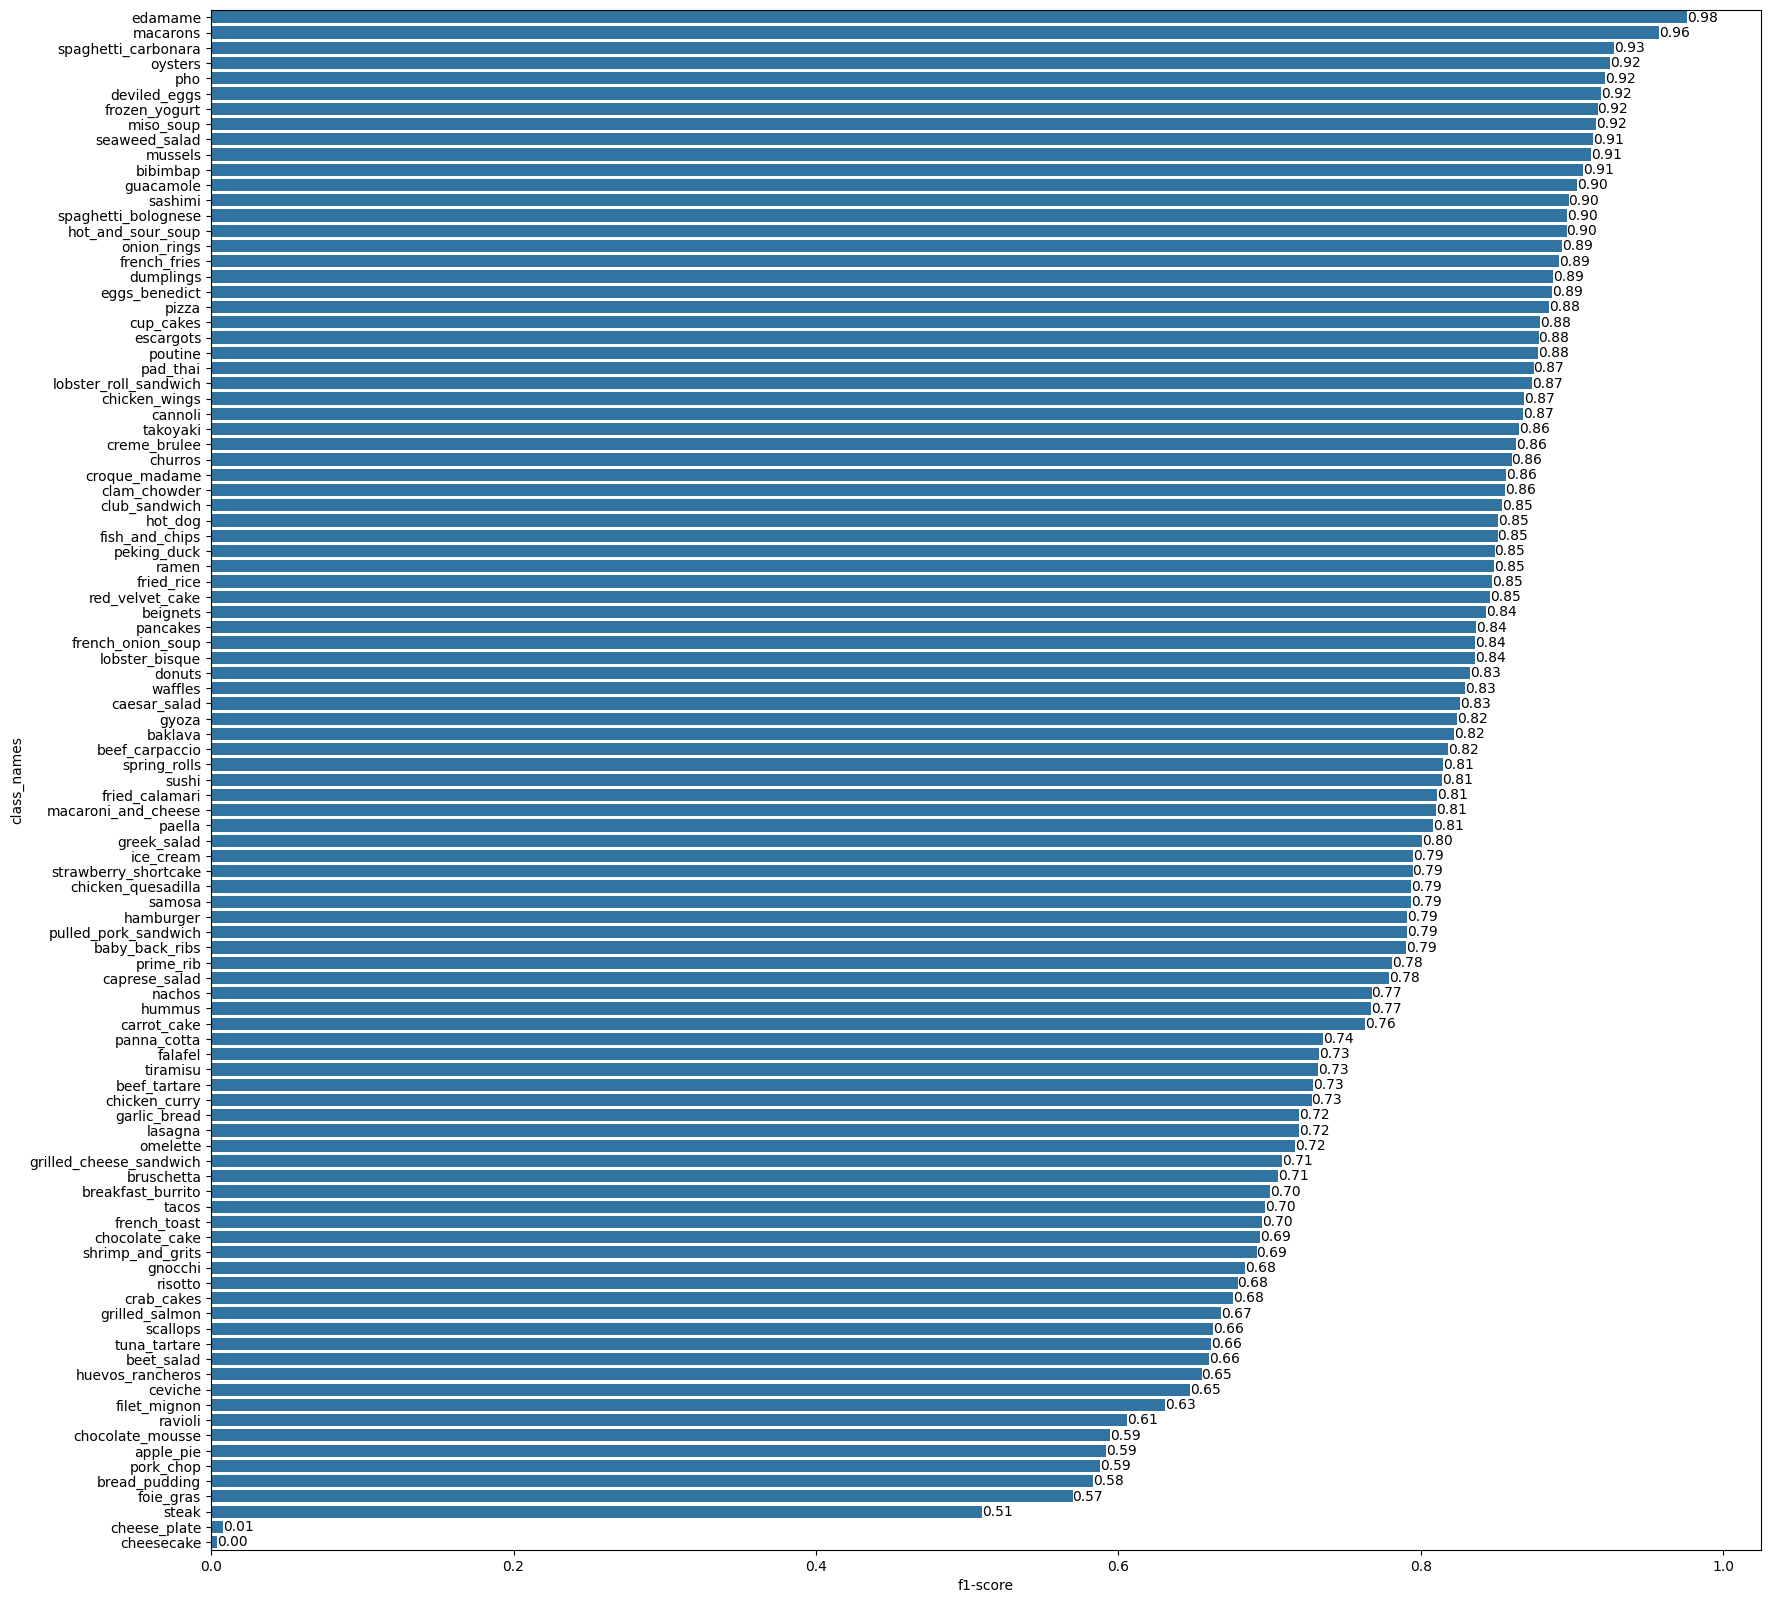

In [76]:
plt.figure(figsize=(20,20))
ax = sns.barplot(data=f1_scores, x='f1-score', y='class_names')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

## Making predictions on Random images

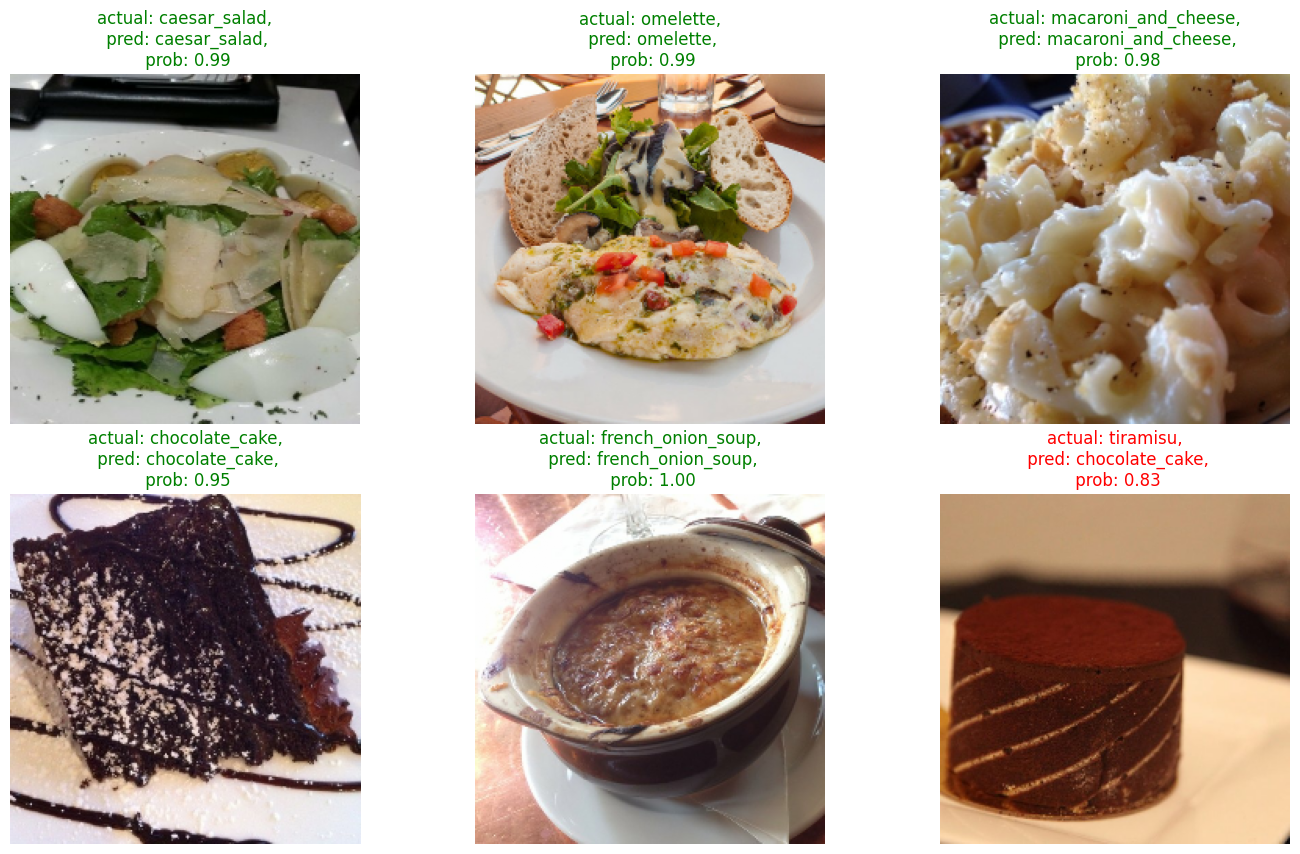

In [241]:
plt.figure(figsize=(17,10))
for i in range(6):
    #choosing the random image from random class
    class_name = random.choice(class_names)
    file_name = random.choice(os.listdir(os.path.join(test_data_dir,class_name)))
    file_path = os.path.join(test_data_dir, class_name, file_name)

    # Loading the image and making predictions
    img = load_and_prep_image(file_path, scale=False)

    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(2, 3, i+1)
    plt.imshow(img/255.)
    if pred_class == class_name:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f"actual: {class_name},\n pred: {pred_class},\n prob: {pred_prob.max():.2f}", c= title_color)
    plt.axis(False)


## Conclusion

I have used EfficientNetB0 model for transfer learning for the Food vision. 

- **Model1:** Feature Extracted Model with 15% validation data ran for 5 epochs achieved `val_accuracy`:**0.7397**

- **Model2:** Feature Extracted Model with all data ran for 5 epochs achieved `val_accuracy`:**0.7425**

- **Model3:** Finetuned Model with 15% validation data ran for 5 epochs achieved `val_accuracy`:**0.7720**

- **Model4:** Finetuned Model Model with all data ran for 13 epochs  with **Early Stopping** achieved `val_accuracy`:**0.7931**

Observation: Model will not perform well while making detection between the foods `cheese plate` and  `cheese cake`